# Model Fitness 

# Content 

[**1. Introducción y Objetivos**](#introducction)

[**2. Análisis exploratorio de datos**](#analisis)

[**3. Modelo para predecir la cancelación de usuarios**](#modelo)

[**4. Crear clústeres de usuarios**](#cluster)

[**5. Conclusiones y recomendaciones**](#conclusiones)

# 1. Introducción y objetivos


La cadena de gimasios: Model Fitness, se enfrenta al problema en la pérdida de sus clientes cuando después de un mes ya no regresan o cuando ya no renuevan sus meses de membresía. Por lo general si un un cliente se une al gimnasio, viene por un tiempo pero después deja de venir lo más probable es que ya no regrese.

Con el propósito de evitar las cancelaciones y pérdidas de los clientes, elaboraremos una estrategia de retención basada en el análisis de los datos de los perfiles de los clientes.

Los objetivos son: 
1. Aprender a predecir la probabilidad de pérdida (para el próximo mes) para cada cliente
2. Elaborar retratos de usuarios típicos: selecciona los grupos más destacados y describe sus características principales
3. Analizar los factores que más impactan la pérdida

Sacar conclusiones básicas y elaborar recomendaciones para mejorar la atención al cliente:

4. Identificar a los grupos objetivo
5. Sugerir medidas para reducir la rotación
6. Describir cualquier otro patrón que observes con respecto a la interacción con los clientes

<div class="alert alert-success">
<b>✔️ Comentario del revisor:</b> Genial que empezamos con el plan todo

# 2. Análisis exploratorio de datos

**2.1 Importación del archivo y librerías**

In [1]:
#Librerías a utilizar
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from plotly import graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.metrics import davies_bouldin_score


In [2]:
# Carga del archivo de clientes, informacion, tamańo, primeras 5 filas
df=pd.read_csv('/datasets/gym_churn_us.csv')
df.info()
print( )
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

gender  Near_Location  Partner  Promo_friends  Phone  Contract_period  \
0       1              1        1              1      0                6   
1       0              1        0              0      1               12   
2       0              1        1              0      1                1   
3       0              1        1              1      1               12   
4       1              1        1              1      1                1   

   Group_visits  Age  Avg_additional_charges_total  Month_to_end_contract  \
0             1   29                     14.227470                    5.0   
1             1   31                    113.202938                   12.0   
2             0   28                    129.448479                    1.0   
3             1   33                     62.669863                   12.0   
4             0   26                    198.362265                    1.0   

   Lifetime  Avg_class_frequency_total  Avg_class_frequency_current_month  \
0         3                   0.020398                           0.000000   
1         7                   1.922936                           1.910244   
2         2                   1.859098                           1.736502   
3         2                   3.205633                           3.357215   
4         3                   1.113884                           1.120078   

   Churn  
0      0  
1      0  
2      0  
3      0  
4      0

Model Fitness nos compartió archivos CSV que contenían los datos sobre cancelación de un mes en concreto e información del mes que lo precedía. El dataset incluye los siguientes campos:

* 'Churn' — la cancelación para el mes en cuestión

Campos de dataset actuales:

  Datos de usuario del mes anterior: 
  * 'gender'- genero 
  * 'Near_Location' — si el usuario vive o trabaja en el vecindario donde se encuentra el gimnasio
  * 'Partner' — si el usuario es un trabajador de una compañía asociada (el gimnasio tiene empresas asociadas cuyos     empleados obtienen descuentos; en esos casos el gimnasio almacena información sobre los empleadores de los clientes)
  * Promo_friends — si el usuario originalmente se inscribió mediante una oferta "trae a un amigo" (se utilizó el código promocional de un amigo cuando pagaron el primer abono)
  * 'Phone' — si el usuario aportó el número de teléfono
  * 'Age'- Edad
  * 'Lifetime' — el tiempo (en meses) desde que el usuario llegó por primera vez al gimnasio

Datos del registro de visitas y compras y datos sobre el estado actual de la membresía
  * 'Contract_period' — 1 mes, 3 meses, 6 meses o 1 año
  *'Month_to_end_contract' — los meses que faltan hasta que expire el contrato
  *'Group_visits' — si el usuario participa en sesiones grupales
  *'Avg_class_frequency_total' — frecuencia media de visitas por semana a lo largo de la vida del cliente
  *'Avg_class_frequency_current_month' — frecuencia media de visitas por semana en el mes anterior
  *'Avg_additional_charges_total' — cantidad total de dinero gastado en otros servicios del gimnasio: cafetería, productos deportivos, cosméticos, masajes, etc.

**2.2 EDA**

Observa el dataset: ¿contiene alguna característica ausente? Estudia los valores promedio y la desviación estándar (utiliza el método describe()).

Observa los valores medios de las características en dos grupos: para los que se fueron (cancelación) y para los que se quedaron (utiliza el método groupby()).

Traza histogramas de barras y distribuciones de características para aquellos que se fueron (cancelación) y para los que se quedaron.

Crea una matriz de correlación y muéstrala.


Podemos ver que el dataframe no contiene valores ausentes en las características de los clientes, disponemos los datos completos con un total de 14 columnas y 4000 registros. Comprobaremos si existen valores duplicados.

In [3]:
duplicados= df.duplicated().sum()
if duplicados == 0:
    print('No existen valores duplicados')
else:
    print('Hay valores duplicados')

No existen valores duplicados


**2.2.1 Estudiaremos la distribucion y valores promedio de las caracteristicas de los clientes través del método de describe.**

In [4]:
df.describe()

gender  Near_Location      Partner  Promo_friends        Phone  \
count  4000.000000    4000.000000  4000.000000    4000.000000  4000.000000   
mean      0.510250       0.845250     0.486750       0.308500     0.903500   
std       0.499957       0.361711     0.499887       0.461932     0.295313   
min       0.000000       0.000000     0.000000       0.000000     0.000000   
25%       0.000000       1.000000     0.000000       0.000000     1.000000   
50%       1.000000       1.000000     0.000000       0.000000     1.000000   
75%       1.000000       1.000000     1.000000       1.000000     1.000000   
max       1.000000       1.000000     1.000000       1.000000     1.000000   

       Contract_period  Group_visits          Age  \
count      4000.000000   4000.000000  4000.000000   
mean          4.681250      0.412250    29.184250   
std           4.549706      0.492301     3.258367   
min           1.000000      0.000000    18.000000   
25%           1.000000      0.000000    27.000000   
50%           1.000000      0.000000    29.000000   
75%           6.000000      1.000000    31.000000   
max          12.000000      1.000000    41.000000   

       Avg_additional_charges_total  Month_to_end_contract     Lifetime  \
count                   4000.000000            4000.000000  4000.000000   
mean                     146.943728               4.322750     3.724750   
std                       96.355602               4.191297     3.749267   
min                        0.148205               1.000000     0.000000   
25%                       68.868830               1.000000     1.000000   
50%                      136.220159               1.000000     3.000000   
75%                      210.949625               6.000000     5.000000   
max                      552.590740              12.000000    31.000000   

       Avg_class_frequency_total  Avg_class_frequency_current_month  \
count                4000.000000                        4000.000000   
mean                    1.879020                           1.767052   
std                     0.972245                           1.052906   
min                     0.000000                           0.000000   
25%                     1.180875                           0.963003   
50%                     1.832768                           1.719574   
75%                     2.536078                           2.510336   
max                     6.023668                           6.146783   

             Churn  
count  4000.000000  
mean      0.265250  
std       0.441521  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       1.000000  
max       1.000000

En promedio observamos que los clientes tienen un periodo vigente de membresia de casi 5 meses, sin embargo la desviacion estandar es de 4.54 por lo que varia bastante desde la media ya sea en mayor o menor meses de inscripción a la membresía, teniendo clientes desde 1 mes de membresía hasta de 1 ańo.

La edad media son de 29 ańos, con una deviacion de 3.25, lo cual podria ser un rango de edades en su mayoria de 25 a 32 ańos. La edad nos indica que este perfil de clientes son jovenes adultos que buscan ejercitarse o relajarse ante sus actividades de trabajo/estudio. 

Los cargos adicionales en el gimnasio indican que en promedio el cliente gasta 146 dolares, sin embargo la desviacion estandar esta muy marcada y existe mucha dispersion en los datos, desde clientes que no consumen servicios/productos adicionales hasta clientes que han llegado a gastar 552 dolares. 

En cuanto a los meses faltantes para que se terminen la membresía son de 4 meses, teniendo un amplio prospecto desde clientes que estan a  1 mes de expirar su contrato y otros con 12 meses restantes. Esto nos indica que tenemos en esta base de datos clientes nuevos como clientes con algun tiempo ya en el gimnasio.

La frecuencia promedio de visita al gimnasio de los clientes es de casi 2 veces por semana, su desviacion estandar es menor 0.97. Sin embargo podemos ver que hay clientes que van hasa 6 dias a la semana pero serian considerados clientes atipicos, dado que el 75% de los clientes tienen una frecuencia de 2.5 de visita por semana.

<div class="alert alert-success">
<b>✔️ Comentario del revisor:</b> Buen inicio!

**2.2.2 Observaremos los valores medios de las características de los dos grupos: para los que se fueron (cancelación) y para los que se quedaron.**



In [5]:
tabla= df.groupby('Churn').mean()
tabla

gender  Near_Location   Partner  Promo_friends     Phone  \
Churn                                                               
0      0.510037       0.873086  0.534195       0.353522  0.903709   
1      0.510839       0.768143  0.355325       0.183789  0.902922   

       Contract_period  Group_visits        Age  Avg_additional_charges_total  \
Churn                                                                           
0             5.747193      0.464103  29.976523                    158.445715   
1             1.728558      0.268615  26.989632                    115.082899   

       Month_to_end_contract  Lifetime  Avg_class_frequency_total  \
Churn                                                               
0                   5.283089  4.711807                   2.024876   
1                   1.662582  0.990575                   1.474995   

       Avg_class_frequency_current_month  
Churn                                     
0                               2.027882  
1                               1.044546

- Clientes que se quedaron: 

    * El 87% viven o trabajan dentro del sector donde se ubica el gimnasio.
    * El 53%, mas de la mitad se incribieron al gimnasio por tener el convenio con su lugar del trabajo. 
    * El 35% se unieron al gimanasio con a traves de un codigo promocional de un amigo. 
    * Empezaron su sucripcion al gimnasio en una media de 5 meses y medio. 
    * Tienen en promedio 30 ańos 
    * Gastan en promedio $158. 
    * Tienen una vigencia en promedio de casi 5 meses en el gimnasio, por lo que este tiempo se podria considerar con el minimo para que los clientes sean leales y se queden. 
    * En promedio asisten al gimnasio una frecuencia de 2 veces a la semana y en todo su tiempo desde que se inscribieron. Sin embargo es punto de alerta ya que es muy baja la frecuencia y en algun momento pueden perder la motivacion y decidir abandonar el gimnasio.
    
- Clientes que cancelaron su membresía: 
    * El 76% de ellos vivían dentro del sector donde se ubica el gimnasio.
    * El 35% se incribieron al gimnasio por convenio en el lugar de su trabajo.
    * El 18% se unieron al gimnasio a traves del codigo de descuento de un amigo.
    * En promedio el contrato de inscripcion fue de casi 2 meses, seguramente al ser un periodo corto lo hicieron para probar el lugar, los equipos y dar un intento a ver si les gustaba. 
    * La media de sus edades era de 27 de ańos. 
    * Su gastos adicionales fueron en promedio $115. Esto quiere decir que tambien se dejaron llevar por los otros servicios que eran ofrecidos y porque vieron valor en en lugar con todo lo que tenia para ofrecerles.
    * Su frecuencia promedio de visita al gimnasio era de 1 vez a la semana, este indicador es bajo ya que a lo mejor no tenian tiempo para asistir o no era exactamente su prioridad asistir con mas regularidad al gimansio.
    
    

A continuacion realizaremos graficos de histograma y de distribuciones para comparar las caracteristicas en ambos grupos. Lo haremos individuales por caracteristicas que contienen respuestas boolenas como tambien combinacion de caracterisitcas para identificar posibles causas o patrones de perdida de los clientes o por el contrario que es lo que mas les gusta a los clientes actuales.

La interpretacion de los datos binarios que tenemos es 0: No, y 1 como Si


**Near Location**

Text(0, 0.5, 'Numero de clientes')

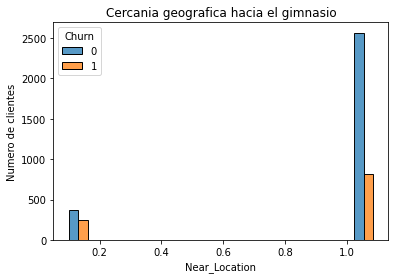

In [6]:
sns.histplot(data=df, x="Near_Location", hue="Churn", multiple="dodge", shrink=.8)
plt.title('Cercania geografica hacia el gimnasio')
plt.ylabel('Numero de clientes')

* Los clientes que permanecieron y no vivian o trabajaban dentro del mismo sector donde estaba el gimnasio es aproxiamdamente un 13%, que en cierta manera les gustó o es de su preferencia este lugar. 
* La moyoria de clientes que permanecieron si viven o trabajan dentro del mismo sector, esto indica que la ubicacion es un papel fundamental para que se mantenga la clientela. 
* Los clientes que abandonaron el gimnasio y si les quedaba cerca llegar, debió haber otro factor por el cual decidieron no ir más.


**Promo_friends**

Text(0, 0.5, 'Numero de clientes')

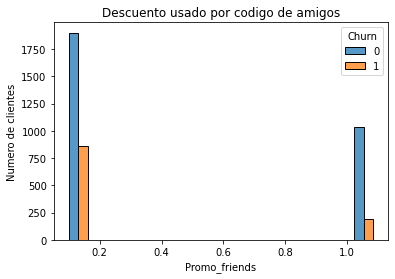

In [7]:
sns.histplot(data=df, x="Promo_friends", hue="Churn", multiple="dodge", shrink=.8)
plt.title('Descuento usado por codigo de amigos')
plt.ylabel('Numero de clientes')

* Los clientes que decidieron abandonar el gimnasio, 250 de ellos si usuaron el codigo promocional por medio de un amigo, para obtener un descuento en su primer mes en el gimnasio. Esto nos puede dar noción de que tal vez su objetivo o prioridad en su dia a dia no era hacer ejercicio, sino que decidieron aprovechar para ver que tal les parecía y entrenar con su amigo.

* Los clientes que se quedaron y si usaron el codigo de descuento, encontraron valor en el servicio del gimansio y quiza se encuentren mas motivados para permanecer. Esto nos dice que los amigos pueden influir a que el cliente adopte otro comportamiento y preferencia por hacer ejercicio acompañado.


<div class="alert alert-success">
<b>✔️ Comentario del revisor:</b> Aqui correcto!

**Phone**

Text(0, 0.5, 'Numero de clientes')

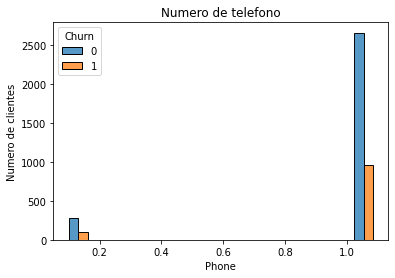

In [8]:
sns.histplot(data=df, x="Phone", hue="Churn", multiple="dodge", shrink=.8)
plt.title('Numero de telefono')
plt.ylabel('Numero de clientes')

* Tenemos los numeros celulares del 90% de tanto clientes actuales como de los que se fueron.
* Existe una ventaja que podemos aprovechar de lanzar camapañas publicitarias, promociones, descuentos, para que los clientes actuales se mantengan y atraer nuevamente a los que abandonaron.
* De igual manera otra forma de concoer en que aspectos el gimnasio puede mejorar o que quizá no fue del gusto de los clientes que se fueron, es mediante una encuesta a traves de Whatsapp o mediante llamada telefonica para conocer el feedback, como se sintieron, que les gustó que no, y cual fue el motivo de su abandono.

**Partner**

Text(0, 0.5, 'Numero de clientes')

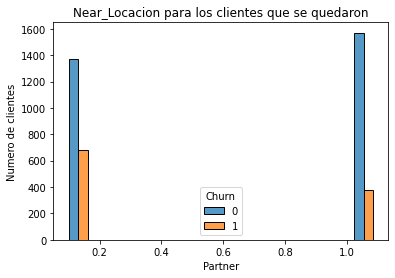

In [9]:
sns.histplot(data=df, x="Partner", hue="Churn", multiple="dodge", shrink=.8)
plt.title('Near_Locacion para los clientes que se quedaron')
plt.ylabel('Numero de clientes')

* La mayoria de clientes que asisten al gimnasio es porque obtuvieron un beneficio muy bueno por parte del convenio entre el gimnasio y su trabajo. Esto definitivamente fue de bastante atracción y retención de los clientes en no cambiarse a otro gimnasio y tampoco abandonarlo ya que debe ser una gran ayuda económica que desean aprovecharla.


<div class="alert alert-success">
<b>✔️ Comentario del revisor:</b> Buen trabajo!

**Meses faltantes para expirar el contrato**

Text(0, 0.5, 'Numero de clientes')

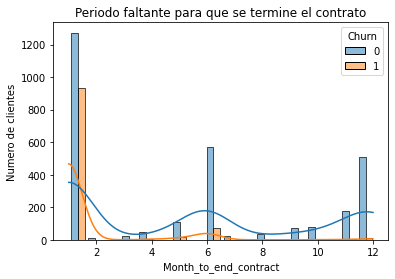

In [10]:
sns.histplot(data=df, x="Month_to_end_contract", hue="Churn", multiple="dodge", shrink=.8,kde=True)
plt.title('Periodo faltante para que se termine el contrato')
plt.ylabel('Numero de clientes')

* La mayoria de clientes ya sea que esten actualmente o hayan abandonado el gimansio, les queda 1 mes para expirar su contrato. En este punto seria importante hacer recuerdos 15 dias antes de terminar su contrato para que el cliente este atento y pueda contar con su planificacion economica para poder renovarlo. 
* De los clientes que se fueron, su gran mayoria les faltaba todavia distrutar de 1 mes del gimansio, esto nos indica que seguramente se aburrieron, estan mas ocupados y no tienen tiempo de regresar o simplemente prefirieron pagar por otro gimnasio. 
* La estrategia es poder mantener los clientes a largo plazo, es por eso que vemos que hay clientes actuales que activaron su memebresia para 6 y 12 meses, esto seguramente fue atraves de un descuento o promocion que por estar periodos mas largo se premia con descuentos en la suscripcion. Este tipo de acciones son las que debemos desarrollar mas y promocionarlas mas.

**Los clientes gastaban mas en los servicios adicionales si vivían o trabajaban en el mismo sector del gimnasio?**


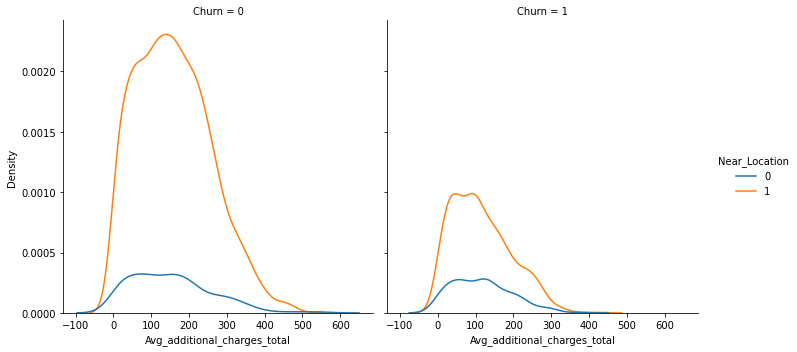

In [11]:
sns.displot(data=df, x="Avg_additional_charges_total", hue="Near_Location", col="Churn", kind="kde")


* Al parecer los clientes que si vivian o trabajan en el mismo sector gastaban mas que aquellos que no estaban cerca. 
* Es grande la diferencia entre la cantidad de gastos de los clientes que permanecieron vs los que se fueron. 
* Para aquellos clientes que no les quedaba cerca el gimansio, ya sea que permaneceiron o se fueron es muy similar el valor de los cargos adicionales.

**El gimnasio recibía ingresos adicionales si los clientes eran parte de un convenio con su lugar de trabajo?**

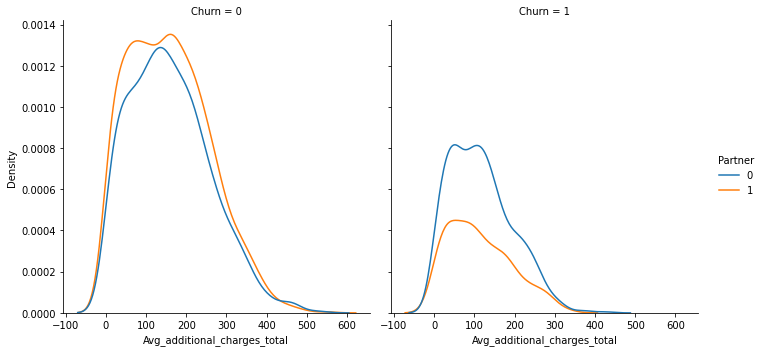

In [12]:
sns.displot(data=df, x="Avg_additional_charges_total", hue="Partner", col="Churn", kind="kde")


* Hubieron mas clientes que no tenian un convenio entre el gimanasio y su lugar de trabajo quienes gastaron entre 100 y 200 dolares.
* Los clientes actuales, sea que tengan un convenio o no su distribucion de gastos adicionales son muy similares.

<div class="alert alert-success">
<b>✔️ Comentario del revisor:</b> Si, aqui correcto!

**Entre mayor era la frecuencia de visita de los clientes mayor era el periodo de su contrato?**

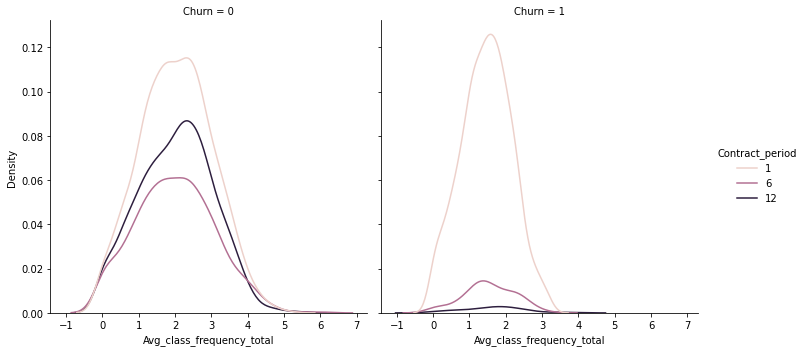

In [13]:
sns.displot(data=df, x="Avg_class_frequency_total", hue='Contract_period', col="Churn", kind="kde")

* Los clientes que se fueron, la gran mayoria solo contrato por 1 mes el servicio, y su frecuencia media de visita total fue de 1 a 3 veces. Se puede decir que unicamente fueron de prueba y no tenian motivacion para continuar o no les gusto el gimnasio.
* Los clientes actuales la mayoria ha contratado por 1 mes, seguido de 12 y 6 meses. Este punto deberia mejorar ya quue la idea es fidelizar al cliente y que contraten mas desde 6 meses en adelante.

**Cual es la distriucion en las edad de los clientes para sus periodos de contrato?**

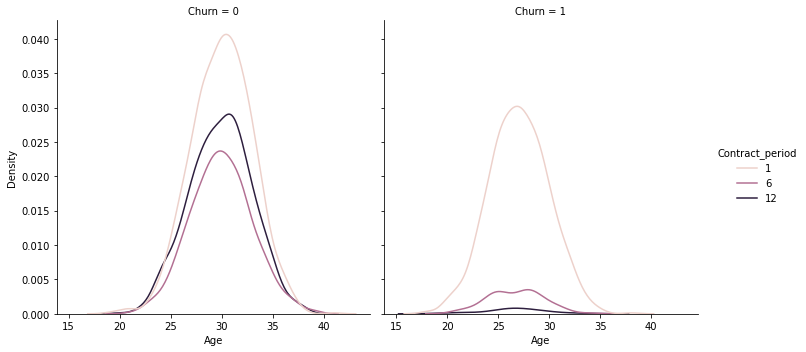

In [14]:
sns.displot(data=df, x="Age", hue='Contract_period', col="Churn", kind="kde")

* Hay un pico que los clientes que se fueron y solo contrataron un mes el servicio, tenian en promedio 27 años.
* Los clientes que si permanecieron su pico de edad media son 30 años, se puede decir que la edad tambien influye a que las personas permanezcan o no.
* Dado que en su mayoria el rango de edades son desde 25 a 35 años para los clientes actuales, mientras que los clientes que se fueron sus rangos de edad son personas mas jovenes, desde los 18 a 35 años. 
* Un punto a evaluar es que se deberia atraer al publico joven tambien o quiza el ambiente da la percepcion que es para gente ya madura y por eso es mas dificil que se puedan adapatar clientes mas jovenes. 

<div class="alert alert-success">
<b>✔️ Comentario del revisor:</b> Me gustan mucho los graficos! Los conclusiones estan correctos!

**Ciclo de vida de los clientes**

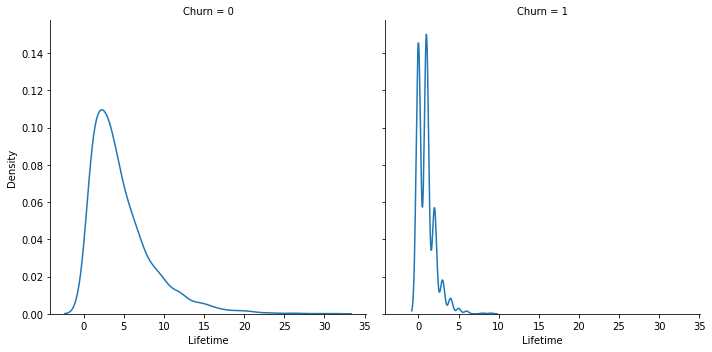

In [15]:
sns.displot(data=df, x="Lifetime", col="Churn", kind="kde")

* La gran mayoria de nuestros clientes actuales son nuevos y tienen 3 meses en el gimnasio. Sin embargo tenemos clientes en menor densidad que sobrepasan el año hasta pocos clientes con casi 3 años. Una estrategia para mantener a los clientes y compensar su fidelidad con el gimansio es ofrecerles algun descuento en su proximo plan de contrato, cortesías en los otros servicios del gimansio, o clases de grupo gratis limitadas. De esta manera el cliente sentira que apoyamos y reconocemos su esfuerzo por cumplir sus objetivos de ejercitarse, bajar de peso, etc.


* Los clientes que se fueron la mayoria estuvieron entre 1 y 2 meses asistiendo al gimnasio, son minimos los que pasaron 4 meses. Esto nos indica que desde el primer mes que ingresan es cuando mas se pueden desmotivar y desanimarse a seguir entrenando y terminan por abandonarlo, una estrategia a implementar es animar a que continuen yendo al gimnasio, recordadonde que tienen un beneficio por su primer mes en otros servicios, etc. 

**Los clientes entrenaron mas frecuentemente el ultimo mes si utilizaron un descuento por un codigo de amigos?**

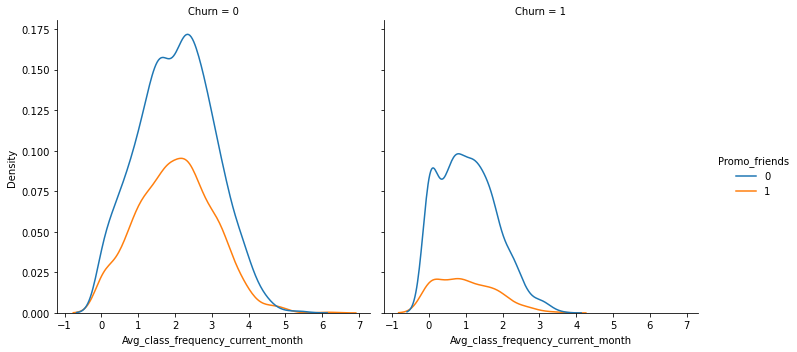

In [16]:
sns.displot(data=df, x="Avg_class_frequency_current_month",hue='Promo_friends' ,col="Churn", kind="kde")

* De los clientes actuales, la mayoria no tiene un descuento y su frecuencia de visita en promedio fue de 2 a 3 veces por semana, sin embargo para aquellos que si ocuparon este descuento su freucencia de visita semanal es el mismo. 

* Los clientes que se fueron y si tenian un descuentos, incluiso no iban ni 1 dia a la semana, como maximo iban 2-3. Esto nos indica que los descuentos para este perfil de clientes no estaba muy acorde a sus necesidades o motivadores para quedarse en el gimnasio.


**2.2.3 Matriz de correlación**

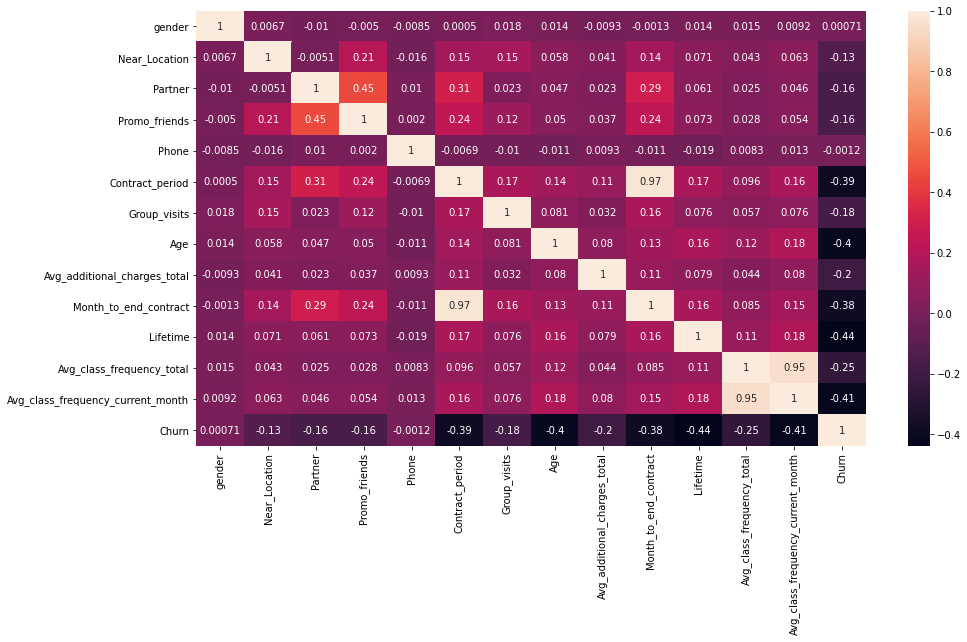

In [17]:
plt.figure(figsize=(15, 8))
sns.heatmap(df.corr(),annot=True)
plt.show()

* La correlacion es fuerte y positiva entre el promedio de frecuencia semanal en el ultimo mes vs el promedio de frecuncia semanal a lo largo de la vida del cliente. 

* Otas caracteristicas que tienen una correlacion positiva en un punto medio son los descuentos de partern y de promo friends, ya que si hay mas promociones implican en que existan mas personas que se incriban al gimansio. 


<div class="alert alert-success">
<b>✔️ Comentario del revisor:</b> Todo bien con esa parte!
    

# 3. Modelo para predecir la cancelación de usuarios

Crearemos un modelo de calsificación binaria para los clientes, donde la característica objetivo es el abandono del usuario al mes siguiente. Primero dividiremos los datos en caracterísitcas y en la variable objetivo.

In [18]:
# divide los datos en características (la matriz X) y una variable objetivo (y)
X = df.drop('Churn', axis = 1)
y = df['Churn']

Dividimos los datos en entrenamiento y en datos de prueba.

In [19]:
# divide los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Entrenaremos el modelo con 2 métodos:

    1. Regresión logistíca 
    2. Bosque aleatorio
 
Para eso definieremos una función que nos entrege: exactitud, precisión y recall utilizando los datos de validación.

In [20]:
#función
def print_all_metrics(y_true, y_pred, y_proba, title = 'Métricas de clasificación'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

**3.1 Modelo de Regresión Logística**

In [21]:
# entrena StandardScaler en el conjunto de entrenamiento
scaler = StandardScaler()
scaler.fit(X_train)

# transforma conjuntos de entrenamiento y de prueba
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [22]:
# configura el algoritmo para el modelo
lr_model = LogisticRegression(random_state=0) 

In [23]:
# entrena al modelo
lr_model.fit(X_train_st,y_train)

LogisticRegression(random_state=0)

In [24]:
# utiliza el modelo entrenado para hacer previsiones
predictions = lr_model.predict(X_test_st)
probabilities = lr_model.predict_proba(X_test_st)[:,1]

In [25]:
print_all_metrics(y_test, predictions, probabilities,title = 'Métricas para regresion logistica:')

Métricas para regresion logistica:
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.83


* El resultado indica que el modelo de regresión logística está funcionando bastante bien en ambos conjuntos de datos y que las clases estan equilibradas porque la exactitud es alta. Al igual que se mantiene un equilibrio entre las dos metricas de precision y recall.



**3.2 Modelo de Bosque Aleatorio**

In [26]:
# define el algoritmo para el nuevo modelo de random forest
rf_model = RandomForestClassifier(n_estimators=100,random_state=0) 
# entrena el modelo de random forest
rf_model.fit(X_train_st,y_train)
# utiliza el modelo entrenado para hacer previsiones
rf_predictions = rf_model.predict(X_test_st)# escribe tu código aquí
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]# escribe tu código aquí
# imprime todas las métricas
print_all_metrics(y_test, rf_predictions, rf_probabilities,title = 'Métricas para random forest:')

Métricas para random forest:
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.81


* Para el bosque aleatorio tambien tiene el mismo valor de exactitud que con el anterior modelo, por lo que ambos tienen una gran clasificación de los datos.
* Si comparamos las demas metricas, la precision y recall del bosque aleatorio son menores, por lo que el modelo de regresion logistica tiene valores mas cercanos al 1 y mejor capacidad para detectar verdaderos positivos y minimizar los falsos positivos. 
* Si tenemos que escoger entre estos dos modelos, la regresion logistica alcanza mejores resultados y se adaptaría mejor para la predicción de abadono de usuarios en el gimnasio para el próximo mes.

# 4. Crear clústeres de usuarios

**4.1 Dejaremos a un lado la columna con datos sobre la cancelación e identificaremos los clústeres de objetos (usuarios):**





In [27]:
df_churn= df.drop('Churn',axis=1)


**4.2  Estandarizar los datos.**

In [28]:
# estandarizar los datos
sc = StandardScaler()
x_sc = sc.fit_transform(df_churn)

**4.3 Utilizaremos la función linkage() para crear una matriz de distancias basada en la matriz de características estandarizada y trazar un dendrograma. Utilizaremos el gráfico resultante para estimar el número de clústeres que se puede destacar.**

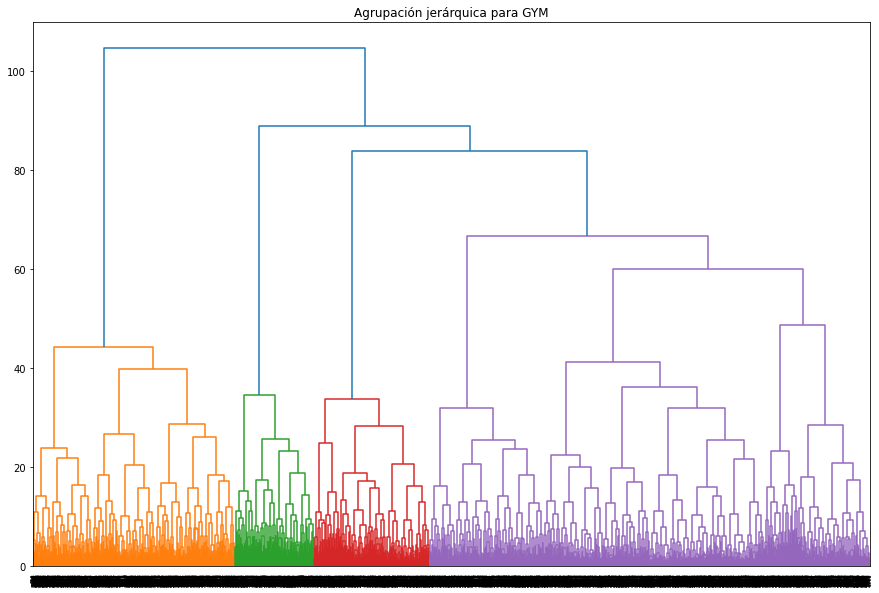

In [29]:
linked = linkage(x_sc, method = 'ward') 
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Agrupación jerárquica para GYM')
plt.show() 

* El gráfico indica a traves de los 4 grupos de colores que ese es el número óptimo de clústeres sugerido. Sin embargo para comprobar que este sea el número de cluster a utilizar, aplicaremos el índice de Davies-Bouldin que es una métrica de validación para los algoritmos de agrupamiento.

<div class="alert alert-success">
<b>✔️ Comentario del revisor:</b> Genial!
    

In [30]:
km4 = KMeans(n_clusters = 4, random_state=0)
km4.fit(x_sc)

KMeans(n_clusters=4, random_state=0)

In [31]:
db_score_4 = davies_bouldin_score(x_sc, km4.labels_)
print(f"El índice de Davis-Bouldin para una partición de 4 clústers es de: {db_score_4:.2f}")

El índice de Davis-Bouldin para una partición de 4 clústers es de: 2.08


In [32]:
km5 = KMeans(n_clusters = 5, random_state=0)
labels = km5.fit_predict(x_sc)

In [33]:
db_score_5 = davies_bouldin_score(x_sc, km5.labels_)
print(f"El íbndice de Davis-Bouldin para una partición de 5 clústers es de: {db_score_5:.2f}")

El íbndice de Davis-Bouldin para una partición de 5 clústers es de: 1.94


* La comparación del índice de Davis con 4 cluster es mayor, y con 5 cluster dio un resultado mas bajo. La interpretacion es que el indice garantiza que el minimo del valor de indice se determina como el numero optimo de clústers.
* En este caso continuaremos el ejercicio aplicando la separación con 5 clústers.

**4.4 Mira los valores medios de característica para clústeres. ¿Hay algo que te llame la atención?**

In [34]:
df['cluster']=labels

In [35]:
df.groupby(['cluster']).mean()

gender  Near_Location   Partner  Promo_friends     Phone  \
cluster                                                               
0        0.502970       0.959406  0.783168       0.574257  1.000000   
1        0.522078       0.862338  0.470130       0.306494  0.000000   
2        0.495050       0.000000  0.463366       0.079208  1.000000   
3        0.485737       1.000000  0.350238       0.240095  1.000000   
4        0.559666       0.976134  0.356802       0.230310  0.998807   

         Contract_period  Group_visits        Age  \
cluster                                             
0              10.889109      0.542574  29.982178   
1               4.787013      0.425974  29.301299   
2               2.352475      0.215842  28.477228   
3               1.948494      0.341521  28.167987   
4               2.669451      0.473747  30.125298   

         Avg_additional_charges_total  Month_to_end_contract  Lifetime  \
cluster                                                                  
0                          160.761016               9.954455  4.736634   
1                          143.957664               4.475325  3.924675   
2                          135.457501               2.198020  2.809901   
3                          131.622204               1.856577  2.440571   
4                          161.657905               2.459427  4.898568   

         Avg_class_frequency_total  Avg_class_frequency_current_month  \
cluster                                                                 
0                         1.982055                           1.974789   
1                         1.847220                           1.716369   
2                         1.660461                           1.477324   
3                         1.247634                           1.012983   
4                         2.852002                           2.850161   

            Churn  
cluster            
0        0.027723  
1        0.267532  
2        0.443564  
3        0.514263  
4        0.068019

* Analizaremos la media de las caracteristicas mas influyentes para cada Cluster que pueden darnos pistas sobre el comportamiento, preferencias de los usuarios como tambien si esto afectó a la tasa de abandono del gimnasio. 

* Cluster 0: 

1. El 95% viven o trabajan cerca del trabajo. 
2. Un 78% se unió al gimnasio por un convenio en su lugar de trabajo. 
3. El 57% utilizaron un codigo de amigos como descuento. 
4. La media del periodo de contrato en el gimnasio fue de casi 11 meses. 
5. La media de sus edades son 30 años. 
6. La media de gastos adicioanles son de $160 uno de los mas altos. 
7. Les faltan como 10 meses para que se caduque su memebresía, por lo que se puede decir que este grupo son clientes que ya tienen entre 4 y 5 meses en el gimnasio. 
8. Unicamente el 2.7% de ellos han abandonado el gimansio, es la tasa mas baja de todos los clusters.


* Cluster 1: 

1. El 86% viven o trabajan cerca del trabajo.
2. El 78% se unieron al gimnasio por un convenio en su lugar de trabajo.
3. El 30% utilizaron el codigo de amigos como descuento.
4. Contrataron su membresia para una media de 5 meses. 
5. Sus edades medias son de 29 años. 
6. La media de gastos en servicios adicionales son de $144.
7. Les falta 5 meses para que su contrato se caduque. 
8. Este grupo ya tiene casi 4 meses asistiendo al gimnasio. 
9. El 26% de los clientes han abandonado el gimansio. 

* Cluster 2:

1. El 0% viven o trabajan cerca del trabajo.
2. El 46% se unieron al gimnasio por un convenio en su lugar de trabajo.
3. El 8% utilizaron el codigo de amigos como descuento.
4. Contrataron su membresia para una media de 2 meses. 
5. Sus edades medias son de 28 años. 
6. La media de gastos en servicios adicionales son de $135.
7. Les falta 2 meses para que su contrato se caduque. 
8. Este grupo ya tiene casi 3 meses asistiendo al gimnasio. 
9. El 44% de los clientes bajo estas características han abandonado el gimansio, una de las tasas mas altas.


* Cluster 3:

1. El 100% viven o trabajan cerca del trabajo.
2. El 35% se unieron al gimnasio por un convenio en su lugar de trabajo.
3. El 24% utilizaron el codigo de amigos como descuento.
4. Contrataron su membresia para una media de 2 meses. 
5. Sus edades medias son de 28 años. 
6. La media de gastos en servicios adicionales son de $131.
7. Les falta menos de 2 meses para que su contrato se caduque. 
8. Este grupo tiene 2 meses y medio asistiendo al gimnasio. 
9. El 51% de los clientes han abandonado el gimansio, es la tasa mas alta de cancelacion del serivicio.


* Cluster 4:

1. El 97% viven o trabajan cerca del trabajo.
2. El 35% se unieron al gimnasio por un convenio en su lugar de trabajo.
3. El 23% utilizaron el codigo de amigos como descuento.
4. Contrataron su membresia para una media de 2 meses y medio. 
5. Sus edades medias son de 30 años. 
6. La media de gastos en servicios adicionales son de $161, es el valor mas alto registrado en los clusters.
7. Les falta 5 meses para que su contrato se caduque. 
8. Este grupo ya tiene casi 5 meses asistiendo al gimnasio. 
9. El 6.8% de los clientes han abandonado el gimansio. 

<div class="alert alert-success">
<b>✔️ Comentario del revisor:</b> Aqui bien!

**4.5 Traza distribuciones de características para los clústeres. ¿Notas algo?**

Realizaremos diagramas de cajas para las sisguientes caracteristicas y observar las desviaciones y concentraciones que existen para cluster y poder comparar.

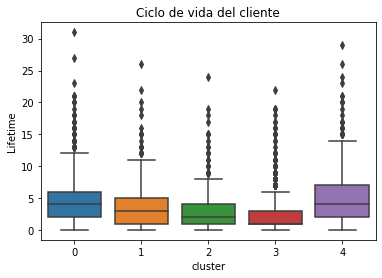

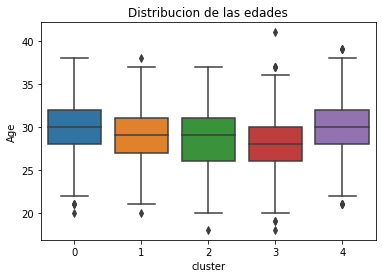

Text(0.5, 1.0, 'Distribucion del periodo de contrato inicial')

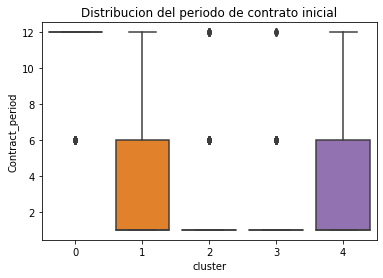

In [36]:
# Diagramas de caja 

sns.boxplot(data=df,x='cluster',y='Lifetime')
plt.title('Ciclo de vida del cliente')
plt.show()
sns.boxplot(data=df,x='cluster',y='Age')
plt.title('Distribucion de las edades')
plt.show()
sns.boxplot(data=df,x='cluster',y='Contract_period')
plt.title('Distribucion del periodo de contrato inicial')



* Ciclo de vida de los clientes:
    Para el cluster 4, sin tomar en cuenta los valores atipicos, registra el maximo de vida de los clientes con 15 meses. En este grupo se encuentran un gran numero de clientes fieles. Al igual que el cluster 0, por tener una media similar de 4 meses y al incluir los valores a tipicos tenemos clientela que ha estado en el gimnasio por más de 30 meses.
    
    
* Distribución de las edades:
El cluster 2 y 3 que fueron los que mayor proporcion de abandono del gimansio, sus edades medias son muy similares a los demas clusteres, de entre 29 y 30 años, por lo que no podriamos decir que la edad es un factor que incluya a que mas clientes abandonen el gimansio.


* Distribucion del periodo de contrato inicial:
Para los clústers 2 y 3 hay valores atípicos por encima de la media, es decir que a pesar de que son los grupos con mayor abandono, hubieron clientes que decidieron hacer una prueba de 1 mes, sin embargo hubieron otros (en su minoría) que contrataron para 6 y 12 meses.  Para el cluster 0 la media son de 12 meses, es el unico gruopo que ha contratado para un periodo a largo plazo.


    

A continuación con el método de FacetGrid, realizaremos histogramas para los clústers en las demas características.

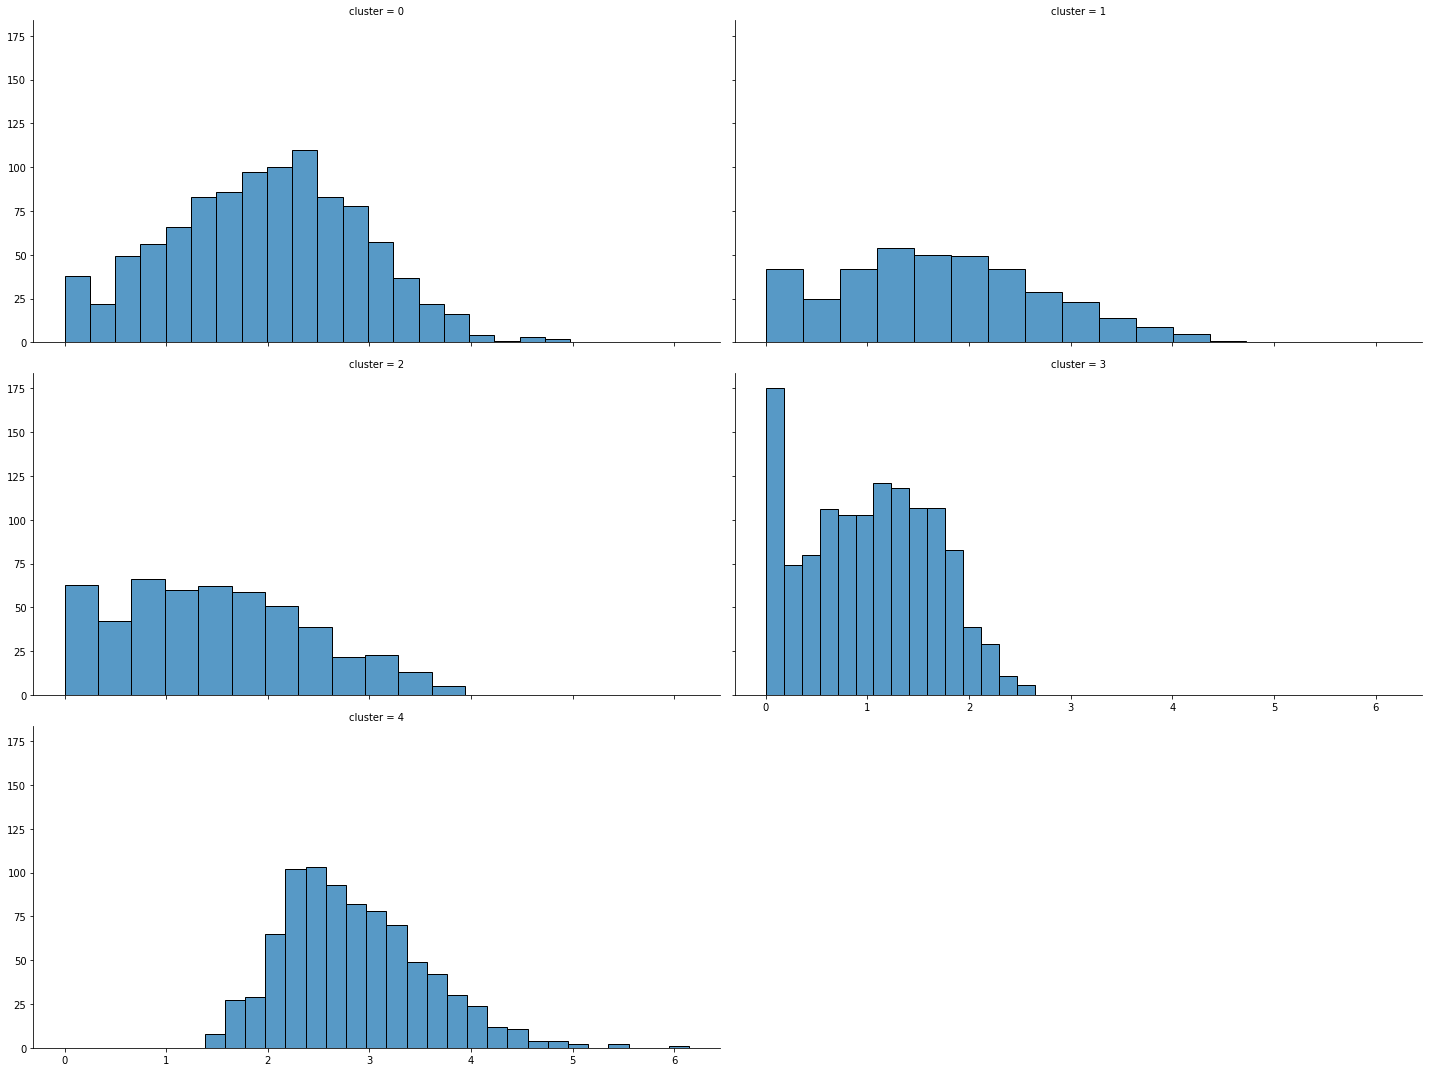

In [37]:
#FacetGrid con el promedio de frecuencia en el último mes
x=sns.FacetGrid(df,col='cluster',col_wrap=2,aspect=2,height=5,sharey=True,sharex=True)
x.map_dataframe(sns.histplot,x='Avg_class_frequency_current_month')
x.add_legend()

plt.show()

* El clúster 4 es el unico que registra visitas a partir de 1 día a la semana, el resto de clùster nos indican que hay clientes que ni siquiera entrenan 1 vez a la semana porque hay registros en 0 en su mayoría para el cluster 3.

* De manera general podemos concluir que nuestra base de clientes total tienen una media de edad en un rango de 28 a 30 ańos, por lo que se relaciona con al frecuencia con la que pueden visitar al gimanasio debido a sus responsabilidades del trabajo y hogar, que quizá les consume mas tiempo y no pueden entrenar la mayoría de días. 


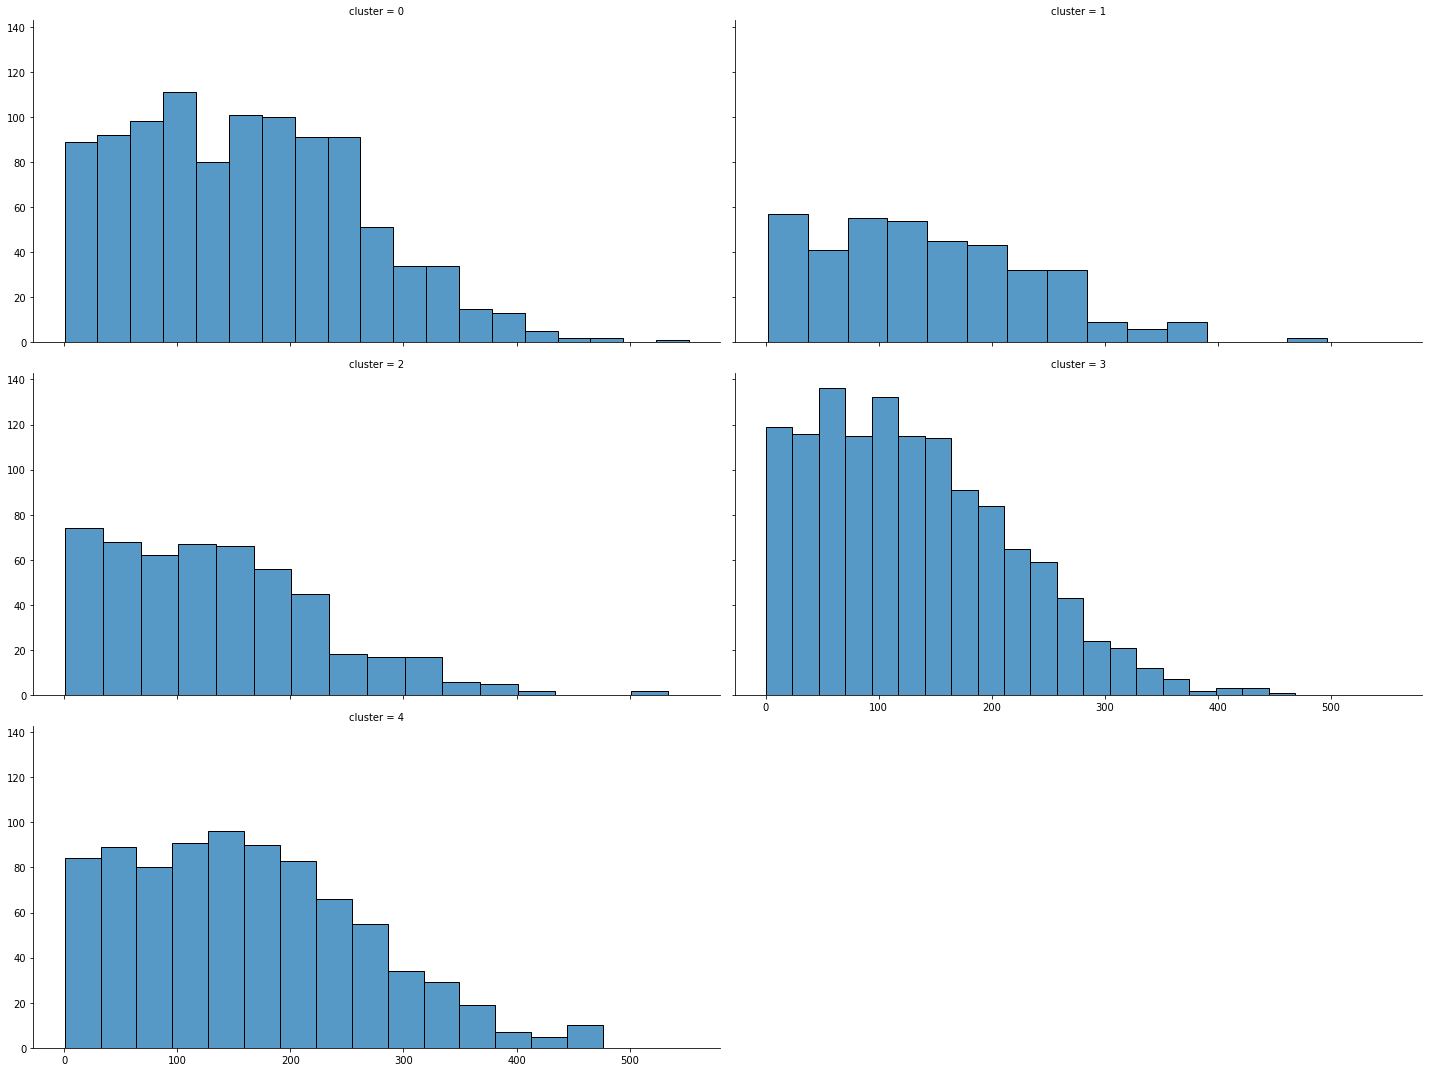

In [38]:
#FacetGrid para la distribución de los cargos adicionales
x=sns.FacetGrid(df,col='cluster',col_wrap=2,aspect=2,height=5,sharey=True,sharex=True)
x.map_dataframe(sns.histplot,x='Avg_additional_charges_total')
x.add_legend()

plt.show()

* El clúster 0 es el grupo que la mayoría de clientes han pagado entre 90 y 110 dólares. Tiene una distribucion similar al cluster 4, entre un rangode 80 a 100 y son los 2 grupos con mayores valores registrados en promedio.
* El clúster 3 registra mayores picos en los montos promedios hasta un maximo de 140, sin embargo su monto promedio va disminuyendo a medida que aumenta mel numero de clientes. 
* El cluster 1 y 2 son los que tienen una distribucion similar, ya que los valores máximos de consumo van en un rango de 60 a 70 dólares. 


<div class="alert alert-success">
<b>✔️ Comentario del revisor:</b> Seria mejor si muestar diferentes clusters con diferentes colores

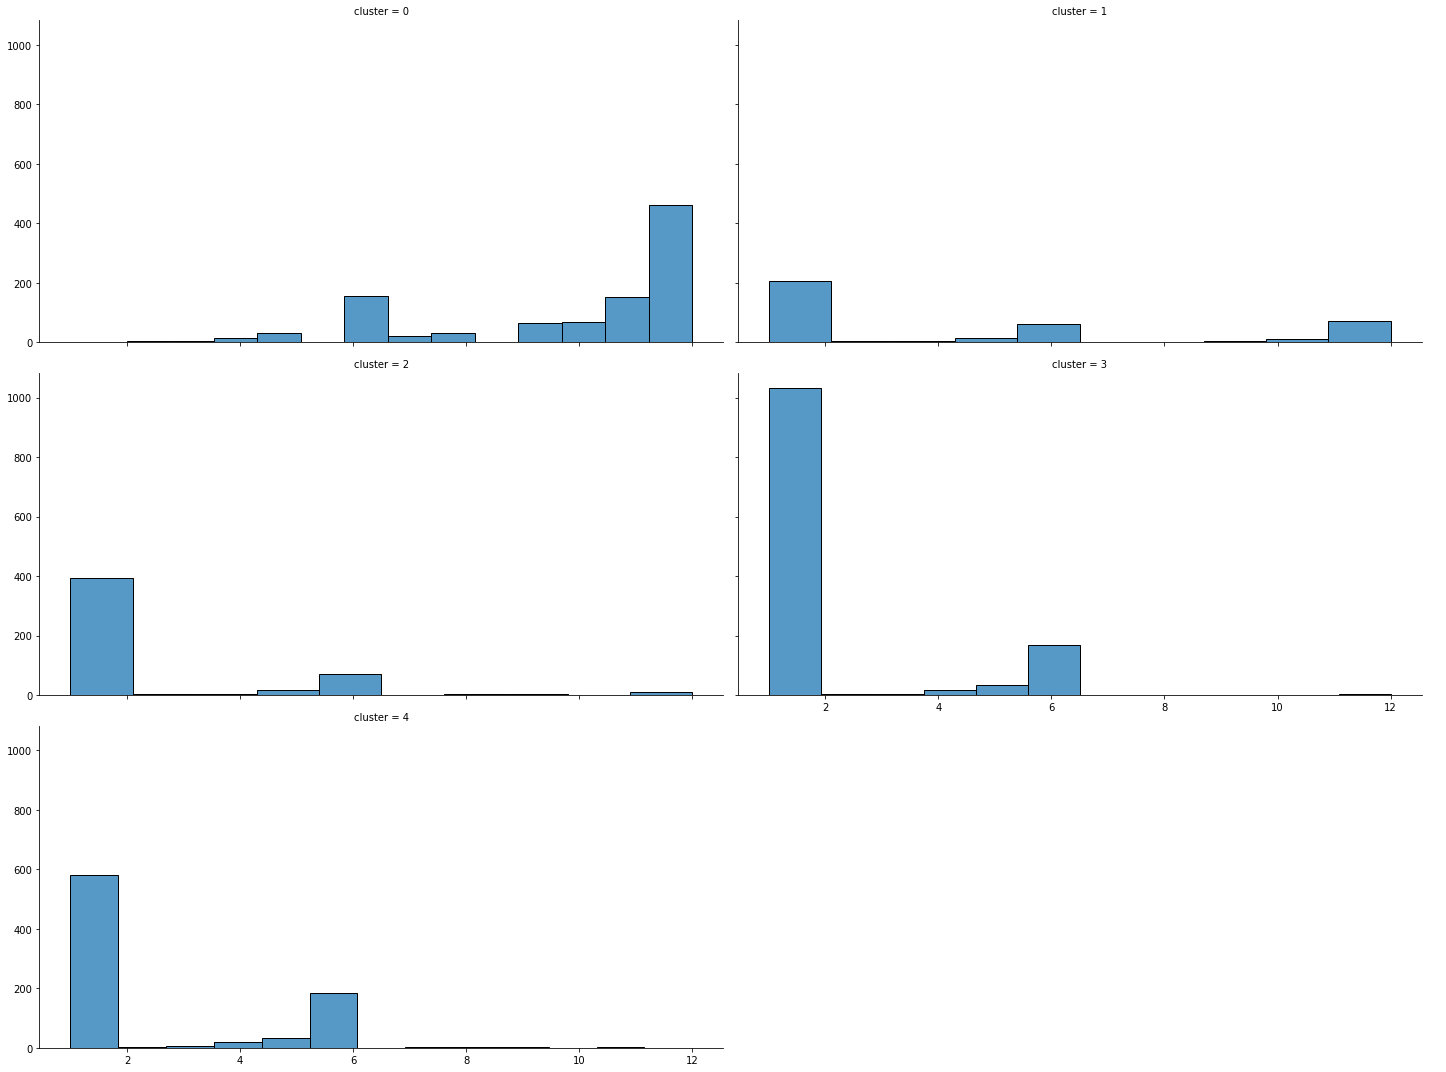

In [39]:
#FacetGrid para la distribucion de los meses faltantes para terminarse el contrato
x=sns.FacetGrid(df,col='cluster',col_wrap=2,aspect=2,height=5,sharey=True,sharex=True)
x.map_dataframe(sns.histplot,x='Month_to_end_contract')
x.add_legend()

plt.show()

* Para los clúster 1,2,3 y 4, en especial los clientes que aun siguen yendo al gimnasio, se deben enviar recordatorios a traves del numero celular o tambien presencialmente, para que puedan recordar que su contrato esta muy proximo a expirar.

* El clúster 1, indica que la mayoria de los clientes hicieron el contrato para largo plazo, teniendo 2 picos en los 6 y 12 meses. 

**4.6 Calcula la tasa de cancelación para cada clúster (utiliza el método groupby()). ¿Difieren en términos de tasa de cancelación? ¿Qué grupos son propensos a irse y cuáles son leales?**

In [40]:
fig=go.Figure([go.Pie(labels=df['cluster'],values=df['Churn'],title='Cancelación para cada clúster')])
fig.show()

* Del total de nuestra base de datos de clientes, el clúster 2 y 3 son los grupos que mayor proporción representan cuando abandonaron el gimnasio, ya que sumados nos da mas del 80%. 
* Esto representa una gran amenaza porque del cluster 3 mas de la mitad de clientes no les gustó, o no encontraron suficientes motivos para mantenerse entrenando. 
* Los clúster 0 y 4 son los de menor tasa de cancelación, como vimos sus caractertisticas son los que estan mas cerca del gimnasio y los que gastan más en servicios adicionales, por lo que la tasa de los que se mantuvieron en el gimnasio fueron mas del 94% que se encontraron satisfechos.


# 5. Conclusiones y recomendaciones

Con el objetivo de mejorar la interacción y retención de clientes, al dividir los clientes en clústers podemos aplicar estrategias diferenciadas para cada grupo. 

1. Clúster 0 y 4: Mantener y aumentar el número de clientes dentro de este grupo objetivo y ofrecerles beneficios adicionales o descuentos por su fidelidad, es decir cuando completen su contrato por 12 meses, esto ayudará a incentivar su constancia en el gimnasio.

2. Clúster 1: A traves de camapañas digitales como publicidad enviada a su Whatsapp especificamente para descuentos en otros servicios del gimnasio siempre y cuando su frecuencia de visita sea mínimo 4 veces por semana durante los 6 primeros meses. Dado que este grupo gastaba una media de $144, quiere decir que si le gustaba los servicios adicionales a pesar de que su frecuencia de visita no era muy alta, la mayoría contrataba planes por 6 meses y esta estretagia sería una forma de premiar por su constancia y esfuerzo. 

3. Clúster 2 y 3: Emplearemos estrategias de exclusivas de promoción, es decir para el grupo de clientes que vivían lejos del gimnasio les ofreceremos un beneficio en un serivicio adicional en el gimnasio que lo podrán utilizar hasta 3 veces solo en el mes 1. De igual manera vemos que este grupo tiene potencial para que entrenen con amigos o se unan a sesiones grupales dado que esto incentiva a que pueda asistir más veces al gimnasio si están acompañados. Finalmente ofreceremos seguimiento a través de los entrenadores para ayudarles a entrenar y cumplir sus objetivos. 

4. Como recomendación para llegar de una manera más directa a los grupos de clientes, es que se pueda recopilar información adicional sobre el perfil de cada uno. Es decir que en el CRM se incluya campos adicionales cuando se cree la ficha del cliente, como conocer primero cual es el objetivo de su inscripción, cuanto tiempo podría dedicar a entrenar en el gimnasio, le interesaría participar en sesiones grupales de baile, pilates, etc. Esta información será de mayor utilidad para afinar los resultados de por qué los clientes deciden abandonar el gimnasio. 

5. Emplear una encuesta de satisfacción a todos los clientes una vez terminen su primer mes. Y volver a ejecutarla también en el largo plazo por ejemplo cuando hayan terminado su primer año. No hay que dejar de escuchar siempre la recomendación de los clientes, como se sintieron entrenando en el gimnasio, que les ha parecido las instalaciones/máquinas, y sobre todo recopilar información para mejorar y mantenerlos lo más satisfechos posibles.


<div class="alert alert-success">
<b>✔️ Comentario del revisor:</b> Muchas gracias por tu trabajo! El proyecto esta aceptado!